# Milestone Project 2: SkimLit

In [1]:
import os
import pickle

In [1]:
!nvidia-smi -L

'nvidia-smi' is not recognized as an internal or external command,
operable program or batch file.


In [ ]:
# !git clone https://github.com/Franck-Dernoncourt/pubmed-rct
# !ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 5), reused 5 (delta 5), pack-reused 25
Unpacking objects: 100% (33/33), done.
Checking out files: 100% (13/13), done.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [2]:
# Check what files are in Pubmed_20k dataset
!ls data/PubMed_20k_RCT_numbers_replaced_with_at_sign/

dev.txt
test.txt
train.txt


In [2]:
# Start our experiments using 20k datasets with numbers replaced with "@" sign
data_dir = 'data/PubMed_20k_RCT_numbers_replaced_with_at_sign/'

In [3]:
# Check all of the filenames in the target directory
import os
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['data/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 'data/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 'data/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt']

## Preprocess data

In [4]:
# Create function to read lines of a document
def get_lines(filename):
  '''
  Reads filename and returns the lines of text as a list

  Args:
    filename: a string contaning the targget filepath.

  Returns:
    A list of strings with one string per line from the target filename
  '''
  with open(filename,'r') as f:
    return f.readlines()

In [5]:
# Lets read in training lines
train_lines = get_lines(data_dir+'train.txt')
train_lines[:20]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [6]:
train_line=train_lines[0].split()
train_line[0]

'###24293578'

In [7]:
def preprocess_text_with_line_numbers(filename):
  '''
  Returns a list of dictionaries of abstract line data

  Takes in filename, read it contents and sorts through each line,
  extractiong things like the target label, the text of a sentence,
  how many sentence are in the current abstract and what sentence
  number the target line is.
  '''
  input_lines=get_lines(filename) # get all lines from filename
  abstract_lines = '' # create an empty abstract
  abstract_samples = [] # create an empty list of abstracts

  for line in input_lines:
    if line.startswith('###'): # check to see if line is ID line
      abstract_id = line
      abstract_lines = '' # reset the abstract string if the line is an ID line
    elif line.isspace(): #check to see if line is a new line
      abstract_line_split = abstract_lines.splitlines() # split abstract into seperate lines
      # Iterate through each line in a single abstract and count them at same time
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {} # crete empty dictionary for each line
        target_text_split = abstract_line.split('\t') # split target label from text
        line_data['target'] = target_text_split[0] # get target label
        line_data['text'] = target_text_split[1].lower() # get target text and lower it
        line_data['line_number'] = abstract_line_number # what number line does the line appear in the abstract?
        line_data['total_lines'] = len(abstract_line_split)-1 # how many total lines are there in the target abstract?
        abstract_samples.append(line_data)

    else:
      abstract_lines+=line
  return abstract_samples


In [8]:
# get data from file and preprocess it
# %%time
train_samples = preprocess_text_with_line_numbers(data_dir+'train.txt')
val_samples = preprocess_text_with_line_numbers(data_dir+'dev.txt')
test_samples = preprocess_text_with_line_numbers(data_dir+'test.txt')
print(len(train_samples),len(val_samples),len(test_samples))

180040 30212 30135


In [9]:
train_samples[:2]

[{'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'line_number': 0,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'line_number': 1,
  'total_lines': 11}]

In [10]:
import pandas as pd
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)
train_df.head(14)

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( @...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at @ we...,9,11


In [11]:
# Distribution of labels in training data
train_df.target.value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

<Axes: ylabel='Frequency'>

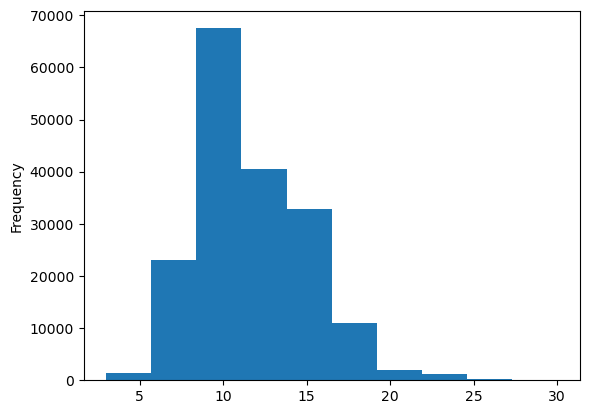

In [12]:
# let's check length of diffrent lines
train_df.total_lines.plot.hist()

### Get list of sentences


In [13]:
# convert abstract text lines into lists
train_sentences = train_df['text'].tolist()
val_sentences = val_df['text'].tolist()
test_sentences = test_df['text'].tolist()
len(train_sentences), len(val_sentences), len(test_sentences)

(180040, 30212, 30135)

## Make numeric labels (ML models require numeric labels)


In [14]:
# one hot encoded labels
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse=False) # we want a non sparse matrix
train_labels_one_hot = one_hot_encoder.fit_transform(train_df['target'].to_numpy().reshape(-1,1))
val_labels_one_hot = one_hot_encoder.fit_transform(val_df['target'].to_numpy().reshape(-1,1))
test_labels_one_hot = one_hot_encoder.fit_transform(test_df['target'].to_numpy().reshape(-1,1))
train_labels_one_hot

C:\Users\PRANAW MISHRA\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
C:\Users\PRANAW MISHRA\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
C:\Users\PRANAW MISHRA\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [15]:
train_labels_one_hot.shape

(180040, 5)

### Label encode labels

In [16]:
# Extract labels ('target' columns and encode them into integers)
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df['target'].to_numpy())
val_labels_encoded = label_encoder.transform(val_df['target'].to_numpy())
test_labels_encoded = label_encoder.transform(test_df['target'].to_numpy())
train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [17]:
# Get class names and no. of classes from labelEncoder instance
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names

(5,
 array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

## Model 0: Getting a baseline

In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create a pipeline
model_0 = Pipeline([
    ('tf-idf',TfidfVectorizer()),
    ('clf',MultinomialNB())
])

# Fit the pipeline to the training data
model_0.fit(X=train_sentences,
            y=train_labels_encoded)

Pipeline(steps=[('tf-idf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [23]:
# Evaluate baseline on validation dataset
k=model_0.score(X=val_sentences,
                 y=val_labels_encoded)
k

0.7218323844829869

In [25]:
j=model_0.score(X=train_sentences,
                 y=train_labels_encoded)
j

0.7516829593423684

In [47]:
# make predictions using our baseline model
baseline_preds = model_0.predict(val_sentences)
baseline_preds

array([4, 1, 3, ..., 4, 4, 1])

### Download helper function script


In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2022-09-02 21:18:05--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-09-02 21:18:05 (109 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
from helper_functions import calculate_results

In [ ]:
# Calculate baseline results
baseline_results = calculate_results(y_true=val_labels_encoded,
                                     y_pred=baseline_preds)
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

## Prepare our data for deep sequence model


In [ ]:
sent_lens = [len(sentence.split()) for sentence in train_sentences]
avg_sent_lens = round(sum([len(sentence.split()) for sentence in train_sentences])/len(train_sentences))
avg_sent_lens,len(sent_lens)

(26, 180040)

(array([4.2075e+04, 8.3771e+04, 3.6877e+04, 1.0945e+04, 3.9310e+03,
        1.4450e+03, 5.6000e+02, 2.2600e+02, 1.0100e+02, 4.5000e+01,
        2.0000e+01, 1.2000e+01, 9.0000e+00, 1.0000e+01, 6.0000e+00,
        2.0000e+00, 3.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00]),
 array([  1.  ,  15.75,  30.5 ,  45.25,  60.  ,  74.75,  89.5 , 104.25,
        119.  , 133.75, 148.5 , 163.25, 178.  , 192.75, 207.5 , 222.25,
        237.  , 251.75, 266.5 , 281.25, 296.  ]),
 <a list of 20 Patch objects>)

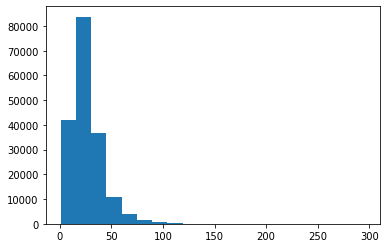

In [ ]:
# What is the distribution look like?
import matplotlib.pyplot as plt
# plt.hist([len(sentence.split()) for sentence in train_sentences], bins=20)
plt.hist(sent_lens,bins=20)

In [ ]:
# How long of a sentence length covers 95% of an example?
import numpy as np
output_seq_len = int(np.percentile(sent_lens, 95))
output_seq_len

55

In [ ]:
# maximum sequence length in the training set
max(sent_lens)

296

### Text Vectorization

In [ ]:
max_tokens = 68000 # taken from table 2 from original paper

In [ ]:
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

# Use default TextVectorization parameters
text_vectorizer = TextVectorization(max_tokens=max_tokens, # how many words in vocabulary(taken from original paper)
                                    output_mode='int', # how to make tokens to numbers
                                    output_sequence_length=output_seq_len) # how long do you want your sequence to be

In [ ]:
# Adapt text vectorizer on training text
text_vectorizer.adapt(train_sentences)

In [ ]:
# Create a sample sentence and tokenize it
sample_sentence = 'There is a flood in my street'
text_vectorizer([sample_sentence])

<tf.Tensor: shape=(1, 55), dtype=int64, numpy=
array([[   61,    20,     8,     1,     5, 25624, 10148,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]])>

In [ ]:
# choose a random sentence from the training dataset and tokenize it
import random
target_sentence = random.choice(train_sentences)
print(f'Original Text:\n {target_sentence}\
n\nvectorized version:')
print(f'\nLength of text: {len(target_sentence.split())}')
print()
text_vectorizer([target_sentence])

Original Text:
 the mean score of body fatigue was @ .n
vectorized version:

Length of text: 9



<tf.Tensor: shape=(1, 55), dtype=int64, numpy=
array([[  2,  57, 101,   4, 239, 648,  10,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0]])>

In [ ]:
# get unique words in the vocabulary
rct_20k_text_vocab = text_vectorizer.get_vocabulary() # get all unique words in training data
top_5_words = rct_20k_text_vocab[:5] # get the mostcommon words
bottom_5_words = rct_20k_text_vocab[-5:] # get the least common words
print(f'Number of words in vocab: {len(rct_20k_text_vocab)}')
print(f'5 most common words: {top_5_words}')
print(f'5 least common words:{bottom_5_words}')

Number of words in vocab: 64841
5 most common words: ['', '[UNK]', 'the', 'and', 'of']
5 least common words:['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [ ]:
# Get the config of our text vectorizer
text_vectorizer.get_config()

{'name': 'text_vectorization',
 'trainable': True,
 'batch_input_shape': (None,),
 'dtype': 'string',
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None}

### Creating an Embedding layer

In [ ]:
from tensorflow.keras import layers
token_embed = layers.Embedding(input_dim=len(rct_20k_text_vocab), # set input shape
                             output_dim=128, # output shape
                             mask_zero=True, # use masking to handle variable lengths(save space)
                             name='token_embedding')
                            #  input_length=output_seq_len) # how long is each input

In [ ]:
# random_sentence = random.choice(train_sentences)
print(f'Original Text:\n {target_sentence}\
        n\nEmbedded version:')

# Embed the random sentence (turn it into dense vectors of fixed size)
embedded_sentence = token_embed(text_vectorizer([target_sentence]))
print(embedded_sentence)
print(f'Embedded sentence shape: {embedded_sentence.shape}')

Original Text:
 the mean score of body fatigue was @ .        n
Embedded version:
tf.Tensor(
[[[-0.02734263 -0.0104951  -0.02879792 ...  0.01410047  0.0160548
    0.00012077]
  [-0.04221198 -0.03364959 -0.02506199 ... -0.04195641 -0.02738318
   -0.01618906]
  [-0.03988757 -0.01171573  0.00534187 ... -0.01957507 -0.04137598
   -0.00014842]
  ...
  [ 0.03913536 -0.02683628 -0.01586833 ...  0.0227995   0.0154599
    0.01816168]
  [ 0.03913536 -0.02683628 -0.01586833 ...  0.0227995   0.0154599
    0.01816168]
  [ 0.03913536 -0.02683628 -0.01586833 ...  0.0227995   0.0154599
    0.01816168]]], shape=(1, 55, 128), dtype=float32)
Embedded sentence shape: (1, 55, 128)


## Creating datasets(making sure our data loads as fast as possible)

In [ ]:
# Turn our data into Tensorflow Datasets
import tensorflow as tf
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))
train_dataset

<TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [ ]:
# Take the TensorSliceDataset's and turn them into prefetched datasets
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE) # here AUTOTUNE means fetch any no. of data u want from pipeline
train_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

## Model 1: Conv1D with token embedding

In [ ]:
# Creating model
import tensorflow as tf
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,),dtype=tf.string)
x = text_vectorizer(inputs)
x = token_embed(x)
x = layers.Conv1D(filters=64,
                  kernel_size=5,
                  strides=1,
                  activation='relu',
                  padding='same')(x)
x = layers.GlobalMaxPooling1D()(x)
outputs = layers.Dense(num_classes,activation='softmax')(x)
model_1 = tf.keras.Model(inputs,outputs,name='Model_1_Conv1D_token_embed')

In [ ]:
model_1.summary()

Model: "Model_1_Conv1D_token_embed"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 55)               0         
 torization)                                                     
                                                                 
 token_embedding (Embedding)  (None, 55, 128)          8299648   
                                                                 
 conv1d (Conv1D)             (None, 55, 64)            41024     
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 5)  

In [ ]:
# Compile the model
model_1.compile(loss='categorical_crossentropy',
                optimizer='Adam',
                metrics=['accuracy'])


In [ ]:
# Fit the model
model_1_history = model_1.fit(train_dataset,
                              steps_per_epoch=int(0.1*len(train_dataset)), # only fit on 10% of the batches for faster training time
                              epochs=3,
                              validation_data=valid_dataset,
                              validation_steps=int(0.1*len(valid_dataset))) # only valid on 10% of batches

Epoch 1/3
562/562 [==============================] - 16s 9ms/step - loss: 0.8497 - accuracy: 0.6787 - val_loss: 0.5897 - val_accuracy: 0.7822
Epoch 2/3
562/562 [==============================] - 5s 9ms/step - loss: 0.5781 - accuracy: 0.7878 - val_loss: 0.5380 - val_accuracy: 0.8005
Epoch 3/3
562/562 [==============================] - 5s 8ms/step - loss: 0.5438 - accuracy: 0.8009 - val_loss: 0.5201 - val_accuracy: 0.8112


In [ ]:
# Evaluate on whole validation dataset
model_1.evaluate(valid_dataset)

945/945 [==============================] - 3s 3ms/step - loss: 0.5230 - accuracy: 0.8064


[0.522988498210907, 0.8064345121383667]

In [ ]:
model_1_pred_probs = model_1.predict(valid_dataset)
model_1_pred_probs, model_1_pred_probs.shape

(array([[6.2023294e-01, 6.4387783e-02, 3.5644774e-03, 3.0817866e-01,
         3.6361881e-03],
        [3.9508897e-01, 3.4923699e-01, 3.8404806e-04, 2.5415087e-01,
         1.1390862e-03],
        [1.7866573e-01, 9.1187125e-03, 1.3933291e-03, 8.1060123e-01,
         2.2100378e-04],
        ...,
        [2.8026529e-04, 3.8476002e-03, 1.1842613e-02, 2.0197478e-04,
         9.8382759e-01],
        [1.5797427e-02, 6.6284323e-01, 2.3609128e-02, 1.1121096e-02,
         2.8662914e-01],
        [1.4399125e-02, 9.7754592e-01, 1.2242303e-03, 3.4633798e-03,
         3.3673185e-03]], dtype=float32), (30212, 5))

In [ ]:
# Convert pred probs to classes
model_1_preds = tf.argmax(model_1_pred_probs, axis=1)
model_1_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 1, 1])>

In [ ]:
model_1_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_1_preds)
model_1_results

{'accuracy': 80.64345293260956,
 'precision': 0.804625707136307,
 'recall': 0.8064345293260956,
 'f1': 0.8046434518564253}

## Model 2: Feature extraction with pretrained embeddings

In [ ]:
import tensorflow_hub as hub
tf_hub_embedding_layer = hub.KerasLayer('https://tfhub.dev/google/universal-sentence-encoder/4',
                       dtype=tf.string,
                       trainable=False)

In [ ]:
# Test out the embedding on a random sentence
random_training_sentence = random.choice(train_sentences)
print(f"Random training sentence:\n{random_training_sentence}\n")
use_embedded_sentence = tf_hub_embedding_layer([random_training_sentence])
print(f"Sentence after embedding:\n{use_embedded_sentence[0][:30]} (truncated output)...\n")
print(f"Length of sentence embedding:\n{len(use_embedded_sentence[0])}")

Random training sentence:
specialized central pathology review could help to avoid overtreatment of patients with bot and inappropriate treatment of patients with ovarian metastases .

Sentence after embedding:
[-0.08424852  0.0543506  -0.01354028 -0.05593877  0.05380913 -0.08143531
 -0.03837959  0.00703039  0.00633966 -0.06360358  0.09514405 -0.0665694
 -0.04303792  0.06422734  0.07173362  0.04507665 -0.09522996 -0.02834133
 -0.0556562   0.01239037  0.00036502  0.06607197  0.03665067 -0.00736072
  0.05957518 -0.03376544 -0.04296045 -0.00943698  0.02772554  0.0623168 ] (truncated output)...

Length of sentence embedding:
512


In [ ]:
inputs = layers.Input(shape=[],dtype=tf.string)
pretrained_embedding = tf_hub_embedding_layer(inputs) # tokenize text nad create embedding of each sequence(512 long vector)
x = layers.Dense(128,activation='relu')(pretrained_embedding)
outputs = layers.Dense(num_classes, activation='softmax')(x)
model_2 = tf.keras.Model(inputs,outputs)

In [ ]:
# model_2 = tf.keras.Sequential([
# sentence_encoder_layer,
# # tf.keras.layers.LSTM(64),
# tf.keras.layers.Dense(64,activation='relu'),
# tf.keras.layers.Dense(num_classes,activation='softmax')
# ])

In [ ]:
model_2.compile(loss='categorical_crossentropy',
                optimizer='Adam',
                metrics=['accuracy'])

In [ ]:
model_2.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None,)]                 0         
                                                                 
 keras_layer (KerasLayer)    (None, 512)               256797824 
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dense_2 (Dense)             (None, 5)                 645       
                                                                 
Total params: 256,864,133
Trainable params: 66,309
Non-trainable params: 256,797,824
_________________________________________________________________


In [ ]:
history_model_2 = model_2.fit(train_dataset,
                              steps_per_epoch=int(0.1*len(train_dataset)),
                              epochs=3,
                              validation_data=valid_dataset,
                              validation_steps=int(0.1*len(valid_dataset)))

Epoch 1/3
562/562 [==============================] - 9s 13ms/step - loss: 0.9166 - accuracy: 0.6515 - val_loss: 0.7955 - val_accuracy: 0.6895
Epoch 2/3
562/562 [==============================] - 7s 12ms/step - loss: 0.7681 - accuracy: 0.7010 - val_loss: 0.7549 - val_accuracy: 0.7041
Epoch 3/3
562/562 [==============================] - 7s 12ms/step - loss: 0.7527 - accuracy: 0.7114 - val_loss: 0.7392 - val_accuracy: 0.7121


In [ ]:
# Evaluate on whole validation dataset
model_2.evaluate(valid_dataset)

945/945 [==============================] - 10s 10ms/step - loss: 0.7421 - accuracy: 0.7124


[0.7421165704727173, 0.7123990654945374]

In [ ]:
model_2_pred_probs = model_2.predict(valid_dataset)
model_2_pred_probs

array([[4.5425966e-01, 3.3681262e-01, 2.1330323e-03, 1.9637151e-01,
        1.0423171e-02],
       [3.4494269e-01, 5.1561362e-01, 3.1188007e-03, 1.3231535e-01,
        4.0095393e-03],
       [2.5883278e-01, 1.5298186e-01, 1.6504569e-02, 5.2983040e-01,
        4.1850321e-02],
       ...,
       [1.8209813e-03, 5.5154418e-03, 5.6981545e-02, 8.8766881e-04,
        9.3479437e-01],
       [3.9071501e-03, 4.5768607e-02, 2.1044946e-01, 1.4607579e-03,
        7.3841405e-01],
       [1.8310620e-01, 2.6484337e-01, 4.8592022e-01, 5.0317827e-03,
        6.1098460e-02]], dtype=float32)

In [ ]:
model_2_preds = tf.argmax(model_2_pred_probs,axis=1)

In [ ]:
model_2_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 2])>

In [ ]:
model_2_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_2_preds)
model_2_results

{'accuracy': 71.23990467363961,
 'precision': 0.7132219825660998,
 'recall': 0.7123990467363961,
 'f1': 0.7097396459032147}

## Model 3: Conv1D with Character embedding

In [ ]:
# make function to split sentence into characters
def split_chars(text):
  return ' '.join(list(text))

split_chars(random_training_sentence)

's p e c i a l i z e d   c e n t r a l   p a t h o l o g y   r e v i e w   c o u l d   h e l p   t o   a v o i d   o v e r t r e a t m e n t   o f   p a t i e n t s   w i t h   b o t   a n d   i n a p p r o p r i a t e   t r e a t m e n t   o f   p a t i e n t s   w i t h   o v a r i a n   m e t a s t a s e s   .'

In [ ]:
# Split sequence-level data splits into character level data splits
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]
print(train_chars[0])

t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .


In [ ]:
import numpy as np

In [ ]:
# what is the average character length?
char_lens = [len(sentence) for sentence in train_sentences]
mean_char_len = np.mean(char_lens)
mean_char_len

149.3662574983337

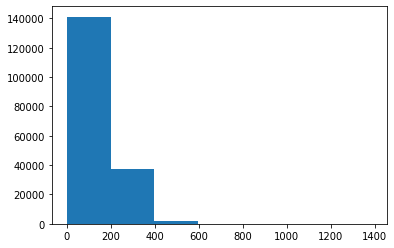

In [ ]:
# Check the distribution of our sequence at character-level
import matplotlib.pyplot as plt
plt.hist(char_lens, bins=7);

In [ ]:
# Find what character length covers 95% of sequences.
output_seq_char_len = int(np.percentile(char_lens,95))
output_seq_char_len

290

In [ ]:
# Get all keyboard character for charr level embedding
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [ ]:
# Create char-level token vectorizer instance
NUM_CHAR_TOKENS = len(alphabet)+2
char_vectorizer = TextVectorization(max_tokens=NUM_CHAR_TOKENS,
                                    output_sequence_length=output_seq_char_len,
                                    standardize='lower_and_strip_punctuation',
                                    name='char_vectorizer')


In [ ]:
# Adapt character vectorizer to training characters
char_vectorizer.adapt(train_chars)

In [ ]:
# Check character vocabulary characteristics
char_vocab= char_vectorizer.get_vocabulary()
print(f'Number of different characters in character vocab: {len(char_vocab)}')
print(f'5 most common characters: {char_vocab[:5]}')
print(f'5 least common characters: {char_vocab[-5:]}')

Number of different characters in character vocab: 28
5 most common characters: ['', '[UNK]', 'e', 't', 'i']
5 least common characters: ['k', 'x', 'z', 'q', 'j']


In [ ]:
# Test our character vectorizer
random_train_chars = random.choice(train_chars)
print(f'classified text:\n{random_train_chars}')
print(f'\nLength of chars: {len(random_train_chars.split())}')
vectorized_chars = char_vectorizer([random_train_chars])
print(f'\nVectorized chars:\n{vectorized_chars}')
print(f'\nLength of vectorized chars: {len(vectorized_chars[0])}')

classified text:
a l t h o u g h   o u r   s t u d y   f a i l e d   t o   d e m o n s t r a t e   t h a t   i n t r a c o r o n a r y   a d m i n i s t r a t i o n   o f   a d o   p r i o r   t o   p c i   l i m i t s   i n f a r c t   s i z e   ,   i n   p a t i e n t s   r e c e i v i n g   e a r l y   p c i   a d o   m i g h t   e n h a n c e   m y o c a r d i a l   s a l v a g e   a n d   h a s   a   f a v o r a b l e   e f f e c t   o n   l v e f   e v o l u t i o n   ,   w h i c h   m a y   h e l p   t o   r e c o n c i l e   a p p a r e n t l y   c o n t r a d i c t o r y   r e s u l t s   o f   p r e v i o u s   s t u d i e s   .

Length of chars: 267

Vectorized chars:
[[ 5 12  3 13  7 16 18 13  7 16  8  9  3 16 10 19 17  5  4 12  2 10  3  7
  10  2 15  7  6  9  3  8  5  3  2  3 13  5  3  4  6  3  8  5 11  7  8  7
   6  5  8 19  5 10 15  4  6  4  9  3  8  5  3  4  7  6  7 17  5 10  7 14
   8  4  7  8  3  7 14 11  4 12  4 15  4  3  9  4  6 17  5  8 11  3  9  4
  25  2  4  6 14

### Create character-level embedding

In [ ]:
char_embed = layers.Embedding(input_dim = len(char_vocab), # number of different characters
                              output_dim = 25, # embedding dimension of each character
                              mask_zero=True,
                              name='char_embed')


In [ ]:
# test our character embedding layer
print(f'Clarified text (before vectorization and embedding):\n{random_train_chars}\n')
char_embed_example=char_embed(char_vectorizer([random_train_chars]))
print(f'Embedded chars (after vectorization and embedding):\n{char_embed_example}\n')
print(f'character embedding shape: {char_embed_example.shape}')

Clarified text (before vectorization and embedding):
a l t h o u g h   o u r   s t u d y   f a i l e d   t o   d e m o n s t r a t e   t h a t   i n t r a c o r o n a r y   a d m i n i s t r a t i o n   o f   a d o   p r i o r   t o   p c i   l i m i t s   i n f a r c t   s i z e   ,   i n   p a t i e n t s   r e c e i v i n g   e a r l y   p c i   a d o   m i g h t   e n h a n c e   m y o c a r d i a l   s a l v a g e   a n d   h a s   a   f a v o r a b l e   e f f e c t   o n   l v e f   e v o l u t i o n   ,   w h i c h   m a y   h e l p   t o   r e c o n c i l e   a p p a r e n t l y   c o n t r a d i c t o r y   r e s u l t s   o f   p r e v i o u s   s t u d i e s   .

Embedded chars (after vectorization and embedding):
[[[-0.01929617  0.01975601 -0.0410663  ... -0.0030736  -0.02254024
    0.0418481 ]
  [ 0.01736672 -0.01559905  0.01102763 ... -0.02713361  0.01403104
   -0.02604963]
  [ 0.03215935  0.00622521  0.02289063 ... -0.04026339  0.04056761
    0.0360003 ]
  ...
  [-0.027

### Finally building our 3rd Model with char_embedding

In [ ]:
# creating model
inputs = layers.Input(shape=(1,),dtype=tf.string)
char_vectors = char_vectorizer(inputs)
char_embeddings = char_embed(char_vectors)
x = layers.Conv1D(filters=64,
                  kernel_size=5,
                  padding='same',
                  activation='relu')(char_embeddings)
x = layers.GlobalMaxPool1D()(x)
outputs = layers.Dense(num_classes, activation='softmax')(x)
model_3 = tf.keras.Model(inputs,outputs,name='model_3_conv1D_char_embedding')


In [ ]:
# Compile the model
model_3.compile(loss='categorical_crossentropy',
                optimizer='Adam',
                metrics=['accuracy'])

In [ ]:
model_3.summary()

Model: "model_3_conv1D_char_embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 char_vectorizer (TextVector  (None, 290)              0         
 ization)                                                        
                                                                 
 char_embed (Embedding)      (None, 290, 25)           700       
                                                                 
 conv1d_1 (Conv1D)           (None, 290, 64)           8064      
                                                                 
 global_max_pooling1d_1 (Glo  (None, 64)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_3 (Dense)             (None, 5

In [ ]:
# Create char datasets
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars,train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars,val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

train_char_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [ ]:
# Fit the model on char dataset
model_3_history = model_3.fit(train_char_dataset,
                              steps_per_epoch=int(0.1*len(train_char_dataset)),
                              epochs=3,
                              validation_data=val_char_dataset,
                              validation_steps=int(0.1*len(val_char_dataset)))

Epoch 1/3
562/562 [==============================] - 4s 6ms/step - loss: 1.2480 - accuracy: 0.5008 - val_loss: 1.0130 - val_accuracy: 0.6034
Epoch 2/3
562/562 [==============================] - 3s 5ms/step - loss: 0.9834 - accuracy: 0.6066 - val_loss: 0.9188 - val_accuracy: 0.6443
Epoch 3/3
562/562 [==============================] - 3s 5ms/step - loss: 0.9205 - accuracy: 0.6417 - val_loss: 0.8622 - val_accuracy: 0.6729


In [ ]:
# Evaluate our model on whole validation dataset
model_3.evaluate(val_char_dataset)

945/945 [==============================] - 3s 4ms/step - loss: 0.8848 - accuracy: 0.6553


[0.8847782015800476, 0.6553356051445007]

In [ ]:
# Make predictions
model_3_pred_probs = model_3.predict(val_char_dataset)
model_3_pred_probs

array([[0.16188076, 0.3851849 , 0.0756766 , 0.2580149 , 0.11924284],
       [0.1409877 , 0.54861164, 0.02131242, 0.1921431 , 0.09694518],
       [0.127043  , 0.20376843, 0.4542828 , 0.12856457, 0.08634129],
       ...,
       [0.02234484, 0.0645511 , 0.18532509, 0.12596756, 0.6018114 ],
       [0.02940587, 0.16870543, 0.3788044 , 0.02861411, 0.39447016],
       [0.47822288, 0.4159639 , 0.01704581, 0.08246743, 0.00630002]],
      dtype=float32)

In [ ]:
# Convert prediction into classes
model_3_preds = tf.argmax(model_3_pred_probs,axis=1)

In [ ]:
model_3_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([1, 1, 2, ..., 4, 4, 0])>

In [ ]:
model_3_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred = model_3_preds)
model_3_results

{'accuracy': 65.53356282271945,
 'precision': 0.647829812375107,
 'recall': 0.6553356282271945,
 'f1': 0.6471603064306872}

## Model 4: Combining pretrained token embedding + character embeddings(hybrid embedding layer)

### 1. setup token input model

In [ ]:
token_inputs = layers.Input(shape=[],dtype=tf.string,name='token_input')
token_embedding = tf_hub_embedding_layer(token_inputs)
token_output = layers.Dense(128, activation='relu')(token_embedding)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_output)

### 2. Setup char inputs/model

In [ ]:
char_inputs = layers.Input(shape=(1,),dtype=tf.string, name='char_input')
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings)
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)

### 3. concatenate token and char inputs (create hybrid token embeddings)

In [ ]:
token_char_concat = layers.Concatenate(name='token_char_hybrid')([token_model.output,
                                                                  char_model.output])


### 4. Create output layers

In [ ]:
combined_dropout = layers.Dropout(0.5)(token_char_concat)
combined_dense = layers.Dense(200, activation='relu')(combined_dropout)
final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(num_classes, activation='softmax')(final_dropout)


### 5. Construct model with char and token inputs

In [ ]:
model_4 = tf.keras.Model(inputs=[token_model.input, char_model.input],
                         outputs=output_layer,
                         name='model_4_token_and_char_embeddings')

In [ ]:
model_4.summary()

Model: "model_4_token_and_char_embeddings"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 token_input (InputLayer)       [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_input[0][0]']             
 tion)                                                                                            
                                                                                                  
 keras_layer (KerasLayer)       (None, 512)          256797824   [

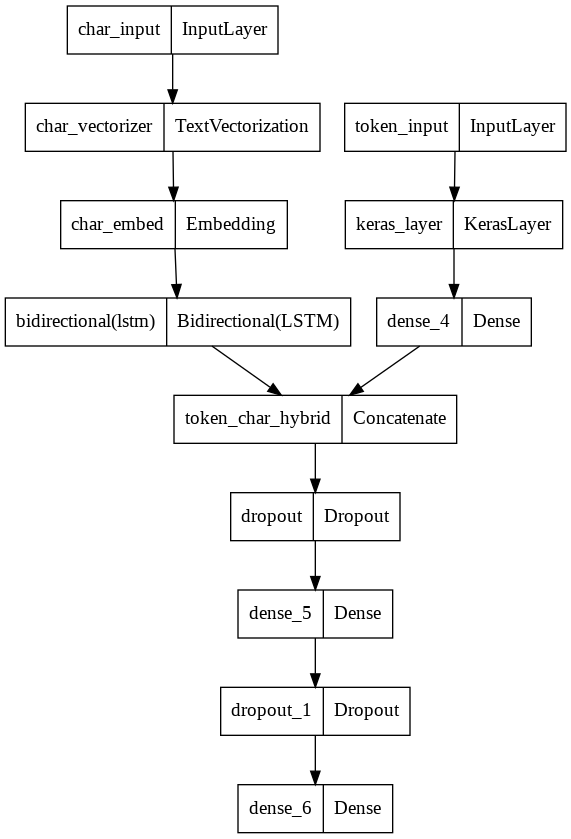

In [ ]:
# Plot hybrid and character mode
from tensorflow.keras.utils import plot_model
plot_model(model_4)

In [ ]:
# Compile our model
model_4.compile(loss='categorical_crossentropy',
                optimizer='Adam',
                metrics=['accuracy'])

### Combining token and character data into a tf.data.Dataset

In [ ]:
train_char_token_data = tf.data.Dataset.from_tensor_slices((train_sentences,train_chars))
train_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data, train_char_token_labels))

# prefetch and batch train data
train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Repeat same steps validation data
val_char_token_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars))
val_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_dataset = tf.data.Dataset.zip((val_char_token_data,val_char_token_labels))
val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
train_char_token_dataset, val_char_token_dataset

(<PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

In [ ]:
# Fit the model
model_4_history = model_4.fit(train_char_token_dataset,
                              steps_per_epoch=int(0.1*len(train_char_token_dataset)),
                              epochs=3,
                              validation_data=val_char_token_dataset,
                              validation_steps=int(0.1*len(val_char_token_dataset)))

Epoch 1/3
562/562 [==============================] - 40s 55ms/step - loss: 0.9626 - accuracy: 0.6197 - val_loss: 0.7728 - val_accuracy: 0.7051
Epoch 2/3
562/562 [==============================] - 27s 49ms/step - loss: 0.7896 - accuracy: 0.6943 - val_loss: 0.7134 - val_accuracy: 0.7317
Epoch 3/3
562/562 [==============================] - 25s 44ms/step - loss: 0.7650 - accuracy: 0.7071 - val_loss: 0.6823 - val_accuracy: 0.7417


In [ ]:
# Make predictions using the token-character model hybrid
model_4_pred_probs = model_4.predict(val_char_token_dataset)
model_4_pred_probs

array([[4.3155801e-01, 3.2656208e-01, 3.8576659e-03, 2.3244427e-01,
        5.5780364e-03],
       [3.2016671e-01, 5.2356398e-01, 5.8084265e-03, 1.4860503e-01,
        1.8557793e-03],
       [2.9565391e-01, 1.1981840e-01, 5.4605614e-02, 5.0254476e-01,
        2.7377345e-02],
       ...,
       [5.7944673e-04, 9.9806637e-03, 7.3208049e-02, 3.3057673e-04,
        9.1590130e-01],
       [4.6180817e-03, 4.5315992e-02, 2.9387116e-01, 2.8440356e-03,
        6.5335077e-01],
       [2.6216871e-01, 4.7126931e-01, 2.0205967e-01, 2.2822523e-02,
        4.1679800e-02]], dtype=float32)

In [ ]:
# Turn prediction probabilities into prediction classes
model_4_preds = tf.argmax(model_4_pred_probs, axis=1)
model_4_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 1])>

In [ ]:
# Get results of token-char-hybrid model
model_4_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_4_preds)
model_4_results

{'accuracy': 73.7091222030981,
 'precision': 0.7385595448525948,
 'recall': 0.7370912220309811,
 'f1': 0.7335016470492729}

## Model 5: Transfer Learning with pretrained token embeddings + Character embeddings + positional embeddings

### Create positional embeddings

In [ ]:
train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


In [ ]:
train_df['line_number'].value_counts()

0     15000
1     15000
2     15000
3     15000
4     14992
5     14949
6     14758
7     14279
8     13346
9     11981
10    10041
11     7892
12     5853
13     4152
14     2835
15     1861
16     1188
17      751
18      462
19      286
20      162
21      101
22       66
23       33
24       22
25       14
26        7
27        4
28        3
29        1
30        1
Name: line_number, dtype: int64

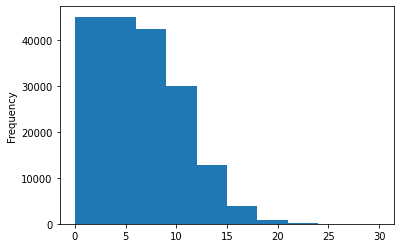

In [ ]:
# Check the distribution of line number column
train_df.line_number.plot.hist()

In [ ]:
# Use Tensorflow to create one-hot encoded tensors of our line number column
train_line_numbers_one_hot = tf.one_hot(train_df['line_number'].to_numpy(),depth=15)
val_line_numbers_one_hot = tf.one_hot(val_df['line_number'].to_numpy(),depth=15)
test_line_numbers_one_hot = tf.one_hot(test_df['line_number'].to_numpy(),depth=15)

In [ ]:
train_line_numbers_one_hot.shape, train_line_numbers_one_hot[:20]

(TensorShape([180040, 15]), <tf.Tensor: shape=(20, 15), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0.,

In [ ]:
# How many different numbers of lines are there?
train_df['total_lines'].value_counts()

11    24468
10    23639
12    22113
9     19400
13    18438
14    14610
8     12285
15    10768
7      7464
16     7429
17     5202
6      3353
18     3344
19     2480
20     1281
5      1146
21      770
22      759
23      264
4       215
24      200
25      182
26       81
28       58
3        32
30       31
27       28
Name: total_lines, dtype: int64

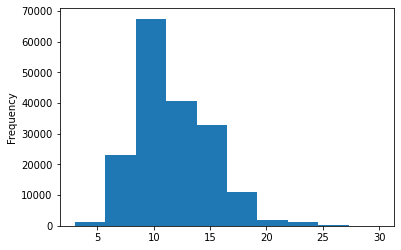

In [ ]:
# Check the distribution of total linnes
train_df.total_lines.plot.hist()

In [ ]:
# Check the coverage of a total lines value of 20
np.percentile(train_df.total_lines, 98)

20.0

In [ ]:
# Use Tensorflow to create one hot encoded tensors of our total_lines column
train_total_lines_one_hot = tf.one_hot(train_df['total_lines'].to_numpy(),depth=20)
val_total_lines_one_hot = tf.one_hot(val_df['total_lines'].to_numpy(),depth=20)
test_total_lines_one_hot = tf.one_hot(test_df['total_lines'].to_numpy(),depth=20)

# Check shape and samples of total lines one-hot tensor
train_total_lines_one_hot.shape,train_total_lines_one_hot[:10]

(TensorShape([180040, 20]), <tf.Tensor: shape=(10, 20), dtype=float32, numpy=
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.

### Bilding a tribird embedding model

In [ ]:
# Token INput
token_inputs = layers.Input(shape=[],dtype=tf.string, name='token_inputs')
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128, activation='relu')(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs = token_embeddings)

# 2. Char inputs
char_inputs = layers.Input(shape=(1,),dtype=tf.string,name='char_inputs')
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(32))(char_embeddings)
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)

# 3. Line numbers inputs
line_number_inputs = layers.Input(shape=(15,),dtype=tf.float32, name='line_number_input')
x = layers.Dense(32,activation='relu')(line_number_inputs)
line_number_model = tf.keras.Model(inputs = line_number_inputs,
                                   outputs=x)

# 4. Total lines inputs
total_lines_inputs = layers.Input(shape=(20,),dtype=tf.float32, name='total_lines_inputs')
y = layers.Dense(32, activation='relu')(total_lines_inputs)
total_line_model = tf.keras.Model(inputs=total_lines_inputs,
                                  outputs=y)

# 5 Combine token and char embedding into a hybrid embedding
combined_embeddings = layers.Concatenate(name='token_char_hybrid_embeddig')([token_model.output,
                                                                             char_model.output])
z = layers.Dense(256, activation='relu')(combined_embeddings)
z = layers.Dropout(0.5)(z)

# 6. Combine positional embeddings with combined token and char embeddings into a tribid embedding
z = layers.Concatenate(name='token_char_positional_embedding')([line_number_model.output,
                                                                total_line_model.output,
                                                                z])

# 7. Create output layer
output_layer = layers.Dense(5, activation='softmax', name='output_layer')(z)

# 8. Put together model
model_5 = tf.keras.Model(inputs=[line_number_model.input,
                                 total_line_model.input,
                                 token_model.input,
                                 char_model.input],
                         outputs = output_layer)

In [ ]:
model_5.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_inputs (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_inputs[0][0]']            
 tion)                                                                                            
                                                                                                  
 token_inputs (InputLayer)      [(None,)]            0           []                               
                                                                                                  
 char_embed (Embedding)         (None, 290, 25)      700         ['char_vectorizer[2][0]']  

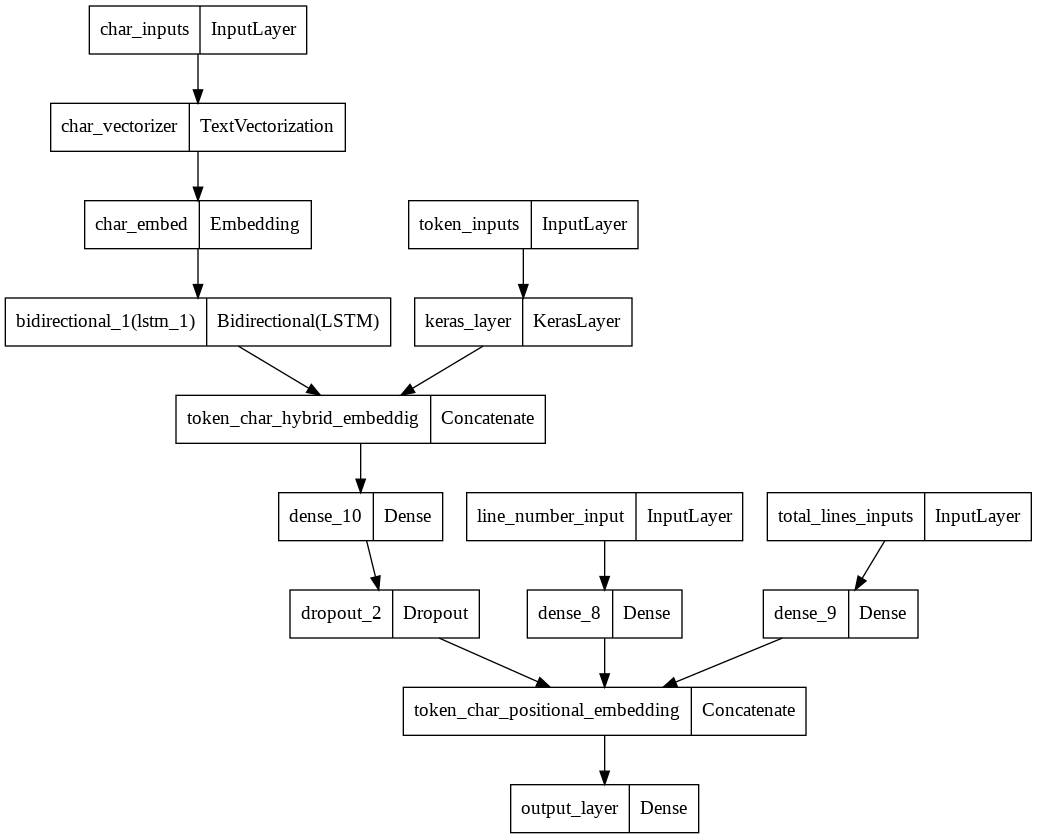

In [ ]:
# Plot the token, char, positional, embedding model
from tensorflow.keras.utils import plot_model
plot_model(model_5)

In [ ]:
# Check which laye of our model is trainable or not
for layers in model_5.layers:
  print(layers, layers.trainable)

<keras.engine.input_layer.InputLayer object at 0x7f387734bf10> True
<keras.layers.preprocessing.text_vectorization.TextVectorization object at 0x7f3778fcde10> True
<keras.engine.input_layer.InputLayer object at 0x7f3879173150> True
<keras.layers.embeddings.Embedding object at 0x7f3778f9bb10> True
<tensorflow_hub.keras_layer.KerasLayer object at 0x7f3868ae6450> False
<keras.layers.wrappers.Bidirectional object at 0x7f387900d7d0> True
<keras.layers.merge.Concatenate object at 0x7f3877ef0c50> True
<keras.engine.input_layer.InputLayer object at 0x7f3879002550> True
<keras.engine.input_layer.InputLayer object at 0x7f387906a250> True
<keras.layers.core.dense.Dense object at 0x7f385db494d0> True
<keras.layers.core.dense.Dense object at 0x7f38790df150> True
<keras.layers.core.dense.Dense object at 0x7f38790175d0> True
<keras.layers.core.dropout.Dropout object at 0x7f3877e27990> True
<keras.layers.merge.Concatenate object at 0x7f385dd65e50> True
<keras.layers.core.dense.Dense object at 0x7f385d

In [ ]:
# Compile token, char, positional model
model_5.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2),# reduces overfitting(examples which are really confident get smoothed a little)
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])



### Create tribrid embedding datasets and fit tribrid model

In [ ]:
# Create training and validation datasets(for all kind of dataset)
train_pos_char_token_data = tf.data.Dataset.from_tensor_slices((train_line_numbers_one_hot, # line numbers
                                                                train_total_lines_one_hot, # total lines
                                                                train_sentences, # train_tokens
                                                                train_chars)) # train chars

train_pos_char_token_labes = tf.data.Dataset.from_tensor_slices(train_labels_one_hot) # train_labels
train_pos_char_token_dataset = tf.data.Dataset.zip((train_pos_char_token_data,train_pos_char_token_labes))
train_pos_char_token_dataset = train_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# VALIDATION DATA
val_pos_char_token_data = tf.data.Dataset.from_tensor_slices((val_line_numbers_one_hot,
                                                             val_total_lines_one_hot,
                                                             val_sentences,
                                                             val_chars))

val_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_pos_char_token_dataset = tf.data.Dataset.zip((val_pos_char_token_data, val_pos_char_token_labels))
val_pos_char_token_dataset = val_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# CHECK INPUT SHAPES
train_pos_char_token_dataset, val_pos_char_token_dataset

(<PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

In [ ]:
# Fit the model
history_model_5 = model_5.fit(train_pos_char_token_dataset,
                              steps_per_epoch=int(0.1*len(train_pos_char_token_dataset)),
                              epochs=3,
                              validation_data=val_pos_char_token_dataset,
                              validation_steps=int(0.1*len(val_pos_char_token_dataset)))

Epoch 1/3
562/562 [==============================] - 39s 56ms/step - loss: 1.0933 - accuracy: 0.7329 - val_loss: 0.9827 - val_accuracy: 0.8059
Epoch 2/3
562/562 [==============================] - 29s 51ms/step - loss: 0.9755 - accuracy: 0.8122 - val_loss: 0.9568 - val_accuracy: 0.8208
Epoch 3/3
562/562 [==============================] - 25s 45ms/step - loss: 0.9611 - accuracy: 0.8173 - val_loss: 0.9504 - val_accuracy: 0.8268


In [ ]:
model_5_pred_probs = model_5.predict(val_pos_char_token_dataset)
model_5_pred_probs

array([[0.5068496 , 0.12143183, 0.01034348, 0.34323096, 0.01814409],
       [0.5399622 , 0.09601446, 0.03885123, 0.315827  , 0.00934509],
       [0.28827077, 0.13966839, 0.14094329, 0.35278693, 0.0783306 ],
       ...,
       [0.03560096, 0.11409248, 0.04843478, 0.02903048, 0.7728413 ],
       [0.02680792, 0.32134098, 0.08334005, 0.02479818, 0.5437129 ],
       [0.1554334 , 0.5870075 , 0.13382056, 0.0359726 , 0.08776588]],
      dtype=float32)

In [ ]:
model_5_preds = tf.argmax(model_5_pred_probs, axis=1)
model_5_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 4, 1])>

In [ ]:
model_5_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_5_preds)
model_5_results

{'accuracy': 82.85780484575666,
 'precision': 0.8273195420305666,
 'recall': 0.8285780484575666,
 'f1': 0.8277464151930481}

### Compare model results

In [ ]:
# Combine model results into a Dataframe
all_model_results = pd.DataFrame({'baseline': baseline_results,
                                  'custom_token_embed_conv1d':model_1_results,
                                  'pretrained_token_embed':model_2_results,
                                  'custom_char_embed_conv1d':model_3_results,
                                  'hybrid_char_token_embed': model_4_results,
                                  'tribrid_pos_char_token_embed': model_5_results})
all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
baseline,72.183238,0.718647,0.721832,0.698925
custom_token_embed_conv1d,80.643453,0.804626,0.806435,0.804643
pretrained_token_embed,71.239905,0.713222,0.712399,0.709740
custom_char_embed_conv1d,65.533563,0.647830,0.655336,0.647160
hybrid_char_token_embed,73.709122,0.738560,0.737091,0.733502
tribrid_pos_char_token_embed,82.857805,0.827320,0.828578,0.827746
